In [25]:
# [START import]
import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import matplotlib.pyplot as plt
import pandas as pd
import time
from scipy.spatial import distance
from scipy import spatial
import numpy as np
import itertools 
%matplotlib  inline
# [END import]

class KMeans_pp:
    def __init__(self, n_clusters, max_iter = 1000, random_seed = 0):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.random_state = np.random.RandomState(random_seed)

    def fit(self, X):
        #ランダムに最初のクラスタ点を決定
        tmp = np.random.choice(np.array(range(X.shape[0])))
        first_cluster = X[tmp]
        first_cluster = first_cluster[np.newaxis,:]
        
        #最初のクラスタ点とそれ以外のデータ点との距離の2乗を計算し、それぞれをその総和で割る
        p = ((X - first_cluster)**2).sum(axis = 1) / ((X - first_cluster)**2).sum()

        r =  np.random.choice(np.array(range(X.shape[0])), size = 1, replace = False, p = p)

        first_cluster = np.r_[first_cluster ,X[r]]

        #分割するクラスター数が3個以上の場合
        if self.n_clusters >= 3:
            #指定の数のクラスタ点を指定できるまで繰り返し
            while first_cluster.shape[0] < self.n_clusters:
                #各クラスター点と各データポイントとの距離の2乗を算出
                dist_f = ((X[:, :, np.newaxis] - first_cluster.T[np.newaxis, :, :])**2).sum(axis = 1)
                #最も距離の近いクラスター点はどれか導出
                f_argmin = dist_f.argmin(axis = 1)
                #最も距離の近いクラスター点と各データポイントとの距離の2乗を導出
                for i in range(dist_f.shape[1]):
                    dist_f.T[i][f_argmin != i] = 0

                #新しいクラスタ点を確率的に導出
                pp = dist_f.sum(axis = 1) / dist_f.sum()
                rr = np.random.choice(np.array(range(X.shape[0])), size = 1, replace = False, p = pp)
                #新しいクラスター点を初期値として加える
                first_cluster = np.r_[first_cluster ,X[rr]] #おそらくクラスターの核である
            
        #最初のラベルづけを行う
        dist = (((X[:, :, np.newaxis] - first_cluster.T[np.newaxis, :, :]) ** 2).sum(axis = 1))
        self.labels_ = dist.argmin(axis = 1)
        labels_prev = np.zeros(X.shape[0])
        count = 0
        self.cluster_centers_ = np.zeros((self.n_clusters, X.shape[1]))

        #各データポイントが属しているクラスターが変化しなくなった、又は一定回数の繰り返しを越した場合は終了
        while (not (self.labels_ == labels_prev).all() and count < self.max_iter):
            #その時点での各クラスターの重心を計算する
            for i in range(self.n_clusters):
                XX = X[self.labels_ == i, :]
                self.cluster_centers_[i, :] = XX.mean(axis = 0)
            
            #各データポイントと各クラスターの重心間の距離を総当たりで計算する
            dist = ((X[:, :, np.newaxis] - self.cluster_centers_.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
            #1つ前のクラスターラベルを覚えておく。1つ前のラベルとラベルが変化しなければプログラムは終了する。
            labels_prev = self.labels_
            #再計算した結果、最も距離の近いクラスターのラベルを割り振る
            self.labels_ = dist.argmin(axis = 1)
            count += 1
            self.count = count
            
    def predict(self, X):
        dist = ((X[:, :, np.newaxis] - self.cluster_centers_.T[np.newaxis, :, :]) ** 2).sum(axis = 1)
        labels = dist.argmin(axis = 1)
        print(labels)
        return labels
    
    #listで返してnp.array()でかこむ
    #パラメータ

In [32]:
def create_data_model(n, count):#csv読み込み
    """Stores the data for the problem."""
    #280個タプル
    data = {}
    # Locations in block units
   
    df = pd.read_csv(f"benchmark/pr107.csv")#データ名
    
    x = df['x'].tolist()
    y = df['y'].tolist()

    data['locations'] = []  # yapf: disable
    for i in range(n):
        data['locations'].append((x[i],y[i]))

    data['num_vehicles'] = 1
    data['depot'] = 0

    return data
    # [END data_model]

# [START distance_callback]
def compute_euclidean_distance_matrix(locations):
    """Creates callback to return distance between points."""
    distances = {}
    for from_counter, from_node in enumerate(locations):
        distances[from_counter] = {}
        for to_counter, to_node in enumerate(locations):
            if from_counter == to_counter:
                distances[from_counter][to_counter] = 0
            else:
                # Euclidean distance
                distances[from_counter][to_counter] = (int(
                    math.hypot((from_node[0] - to_node[0]),
                               (from_node[1] - to_node[1]))))
    return distances
    # [END distance_callback]


# [START solution_printer]
def print_solution(manager, routing, solution, data, route_scatter):
    """Prints solution on console."""
    print('Objective: {}'.format(solution.ObjectiveValue()))
    index = routing.Start(0)
    plan_output = 'Route:\n'
    route_distance = 0
    while not routing.IsEnd(index):
        plan_output += ' {} ->'.format(manager.IndexToNode(index))
        route_scatter.append(int(format(manager.IndexToNode(index))))
        previous_index = index
        index = solution.Value(routing.NextVar(index))
        route_distance += routing.GetArcCostForVehicle(previous_index, index, 0) #route順の取得
    route_scatter.append(0)
    plan_output += ' {}\n'.format(manager.IndexToNode(index))
   # print(plan_output)
    plan_output += 'Objective: {}m\n'.format(route_distance)

def cluster_solution(manager, routing, solution, data):
    plot_data = data
    
#    n = 280#タプル数

    x = []
    y = []
    route_scatter = []
    x2 = []
    y2 = []

    k_means_data = []
    
    data_length = len(plot_data)
    for i in range(data_length):
        x.append(plot_data[i][0])
        y.append(plot_data[i][1])

    print_solution(manager, routing, solution, data, route_scatter)
    print(route_scatter)
     
    #最適化の座標
    for i in route_scatter:
        x2.append(x[i])
        y2.append(y[i])

    for i in range(data_length):
        k_means_data.append([x2[i],y2[i]])
    
    k_means_data = np.array(k_means_data)

    print(f"route:{route_scatter}")
    
    return route_scatter
    
def TSP_solver(kmeans_data):
    """Entry point of the program."""
    # Instantiate the data problem.
    # [START data]
    data = kmeans_data
    # [END data]
    #print(data)

    # Create the routing index manager.
    # [START index_manager]
    manager = pywrapcp.RoutingIndexManager(len(data), 1, 0)
    # [END index_manager]

    # Create Routing Model.
    # [START routing_model]
    routing = pywrapcp.RoutingModel(manager)
    # [END routing_model]

    # [START transit_callback]
    distance_matrix = compute_euclidean_distance_matrix(data)

    def distance_callback(from_index, to_index):
        """Returns the distance between the two nodes."""
        # Convert from routing variable Index to distance matrix NodeIndex.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)

        return distance_matrix[from_node][to_node]

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    # [END transit_callback]

    # Define cost of each arc.
    # [START arc_cost]
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    # [END arc_cost]

    # Setting first solution heuristic.
    # [START parameters]
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)
    # [END parameters]

    # Solve the problem.
    # [START solve]
    solution = routing.SolveWithParameters(search_parameters)
    # [END solve]

    # Print solution on console.
    # [START print_solution]
    if solution:
        return cluster_solution(manager, routing, solution, data)
    # [END print_solution]

In [33]:
#近い値取得
def find_nearest_vector(array, value):
    idx = np.array([np.linalg.norm(x+y) for (x,y) in array-value]).argmin()
    return array[idx]

def clu_approximation(cluster, max_x, max_y):
    clu = cluster
    val = np.array([max_x, max_y])
    get_val = []
    get_val.append(cluster[spatial.KDTree(cluster).query(val)[1]])
    get_val.append(find_nearest_vector(cluster, val))
    idx = clu.index(get_val[0])
    
    return get_val, idx

#始点入れ替え
def scatter_replace(scatter, appro, idx):
    replace_scatter = scatter
    del replace_scatter[idx]
    replace_scatter.insert(0, appro[0])
    print(replace_scatter)
    
    return replace_scatter
    
#クラスター平均
def cluster_average(x, y):
    average = []
    x_n = sum(x)
    y_n = sum(y)
    
    x_n = x_n / len(x)
    y_n = y_n / len(y)
    
    average.append(x_n)
    average.append(y_n)
    
    return average

#最小の値
#クラスターの数に合わせて増やす
def min_index(num_lists, sort_n):
    min_num = 0
    
    if num_lists[0] == sort_n:
        min_num = 0
    elif num_lists[1] == sort_n:
        min_num = 1
    elif num_lists[2] == sort_n:
        min_num = 2
    elif num_lists[3] == sort_n:
        min_num = 3
    elif num_lists[4] == sort_n:
        min_num = 4
    
    return min_num

#次のクラスターとの距離を測る
#クラスターの数に合わせて増やす
def cluster_distance(next_cluster, clu_dist):   
    dist0 = distance.euclidean((clu_dist[next_cluster][0], clu_dist[next_cluster][1]),(clu_dist[0][0], clu_dist[0][1]))
    dist1 = distance.euclidean((clu_dist[next_cluster][0], clu_dist[next_cluster][1]),(clu_dist[1][0], clu_dist[1][1]))
    dist2 = distance.euclidean((clu_dist[next_cluster][0], clu_dist[next_cluster][1]),(clu_dist[2][0], clu_dist[2][1]))    
    dist3 = distance.euclidean((clu_dist[next_cluster][0], clu_dist[next_cluster][1]),(clu_dist[3][0], clu_dist[3][1]))
    dist4 = distance.euclidean((clu_dist[next_cluster][0], clu_dist[next_cluster][1]),(clu_dist[4][0], clu_dist[4][1]))
    
    return dist0, dist1, dist2, dist3, dist4

In [34]:
#総当たりで一番近い距離を探す
def clu_range(first_average, next_average, first_clu, next_clu):
    first_range_cluster = []
    next_range_cluster = []
    
    first_cluster = []
    for i in range(len(first_clu[0])-1):
        first_cluster.append([first_clu[0][i], first_clu[1][i]])
    next_cluster = []
    for  i in range(len(next_clu[0])-1):
        next_cluster.append([next_clu[0][i], next_clu[1][i]])

    #ここから
    for i in range(len(first_cluster)):
            first_range_cluster.append(first_cluster[i])
        
    for i in range(len(next_cluster)-1):
            next_range_cluster.append(next_cluster[i])
    #ここまでに改良を加えれば精度は上がる
#    print(f"first_range_cluster:{first_range_cluster}")
#    print(f"next_range_cluster:{next_range_cluster}")
    min_dist = 100000
    near = []
    p = itertools.product(first_range_cluster, next_range_cluster) #全組み合わせ
    for v in p:
        if min_dist > distance.euclidean((v[0][0], v[0][1]),(v[1][0], v[1][1])):
            min_dist = distance.euclidean((v[0][0], v[0][1]),(v[1][0], v[1][1]))
            near = v[0][0], v[0][1], v[1][0], v[1][1]
#    print(min_dist)
#    print(near)
    
    return near

In [35]:
#入れ替え
def replace(first_route_index, next_route_index, near):
    first_replace = first_route_index
    next_replace = next_route_index
    
    first_route = []
    next_route = []
    for  i in range(len(first_route_index[0])-1):
        first_route.append([first_route_index[0][i], first_route_index[1][i]])
    for i in range(len(next_route_index[0])-1):
        next_route.append([next_route_index[0][i], next_route_index[1][i]])
    first_near = [near[0], near[1]]
    next_near = [near[2], near[3]]
#    print(f"first_replace(削除前):{first_replace}")
#    print(f"削除したいindex:{first_route.index(first_near)}")
    
    del first_replace[0][-1]
    del first_replace[1][-1]
    
    del first_replace[0][first_route.index(first_near)]
    del first_replace[1][first_route.index(first_near)]
#    print(f"first_replace(削除後):{first_replace}")
    del next_replace[0][next_route.index(next_near)]
    del next_replace[1][next_route.index(next_near)]
    
    first_replace[0].append(near[0])
    first_replace[1].append(near[1])
    next_replace[0].insert(0, near[2])
    next_replace[1].insert(0, near[3])
    

#    print(f"first_replace(変更):{first_replace}")
    return first_replace, next_replace

In [36]:
def main(count):
    stratTime = time.time() #プログラムの開始時刻
    
    n = 107#データ個数
    k = 5#クラスタリング数
    
    data = create_data_model(n, count) #data 辞書型
    
    #kmeans処理
    
    kmeans_data = data['locations']#data
    
    x = []
    y = []
    
    for i in range(len(kmeans_data)):
        x.append(kmeans_data[i][0])
        y.append(kmeans_data[i][1])
    
    kmeans_data = np.array(kmeans_data)
    
    model =  KMeans_pp(k)
    model.fit(kmeans_data)
    
    plt.figure(figsize = (15,15))

    labels = model.labels_

    cluster_data =[]
    markers = ["+", "*", "o", "v", "2"]
    color = ['r', 'b', 'g', 'y', 'm']
    for i in range(k):
        p = kmeans_data[model.labels_ == i, :]
        cluster_data.append(p)
        plt.scatter(p[:, 0], p[:, 1], marker = markers[i], color = color[i])
    # [END solution_printer]
    
    #clusterの分の箱とクラスターだけで分割
    clu_scatter0 = []
    clu_scatter1 = []
    clu_scatter2 = []
    clu_scatter3 = []
    clu_scatter4 = []
    
    #ここで取得したクラスターを後で順番を取ったもので回す
    for i in range(len(cluster_data[0])):
        clu_scatter0.append(tuple(cluster_data[0][i]))
    for i in range(len(cluster_data[1])):
        clu_scatter1.append(tuple(cluster_data[1][i]))
    for i in range(len(cluster_data[2])):
        clu_scatter2.append(tuple(cluster_data[2][i]))
    for i in range(len(cluster_data[3])):
        clu_scatter3.append(tuple(cluster_data[3][i]))
    for i in range(len(cluster_data[4])):
        clu_scatter4.append(tuple(cluster_data[4][i]))

    #先に手法として近くのクラスターと入れ替えを行う
    max_x = max(x)/2 #データ内のxの最大値
    max_y = max(y)/2#データ内のyの最大値
    approximation0, idx0 = clu_approximation(clu_scatter0, max_x, max_y)
    replace_scatter0 = scatter_replace(clu_scatter0,  approximation0, idx0)
    approximation1, idx1 = clu_approximation(clu_scatter1, max_x, max_y)
    replace_scatter1 = scatter_replace(clu_scatter1,  approximation1, idx1)
    approximation2, idx2 = clu_approximation(clu_scatter2, max_x, max_y)
    replace_scatter2 = scatter_replace(clu_scatter2,  approximation2, idx2)
    approximation3, idx3 = clu_approximation(clu_scatter3, max_x, max_y)
    replace_scatter3 = scatter_replace(clu_scatter3,  approximation3, idx3)
    approximation4, idx4 = clu_approximation(clu_scatter4, max_x, max_y)
    replace_scatter4 = scatter_replace(clu_scatter4,  approximation4, idx4)
    #route順
    solve0 = TSP_solver(replace_scatter0)
    solve1 = TSP_solver(replace_scatter1)
    solve2 = TSP_solver(replace_scatter2)
    solve3 = TSP_solver(replace_scatter3)
    solve4 = TSP_solver(replace_scatter4)
     
    #並び替えたもの
    route_solve0 = []
    route_solve1 = []
    route_solve2 = []
    route_solve3 = []
    route_solve4 = []
    
    #ここに手法を加える
    for i in solve0:
        route_solve0.append(replace_scatter0[i])
    route_x0 = []
    route_y0 = []
    for i  in range(len(route_solve0)):
        route_x0.append(route_solve0[i][0])
        route_y0.append(route_solve0[i][1])
    
    for i in solve1:
        route_solve1.append(replace_scatter1[i])
    route_x1 = []
    route_y1 = []
    for i  in range(len(route_solve1)):
        route_x1.append(route_solve1[i][0])
        route_y1.append(route_solve1[i][1])
        
    for i in solve2:
        route_solve2.append(replace_scatter2[i])
    route_x2 = []
    route_y2 = []
    for i  in range(len(route_solve2)):
        route_x2.append(route_solve2[i][0])
        route_y2.append(route_solve2[i][1])
    
    for i in solve3:
        route_solve3.append(replace_scatter3[i])
    route_x3 = []
    route_y3 = []
    for i  in range(len(route_solve3)):
        route_x3.append(route_solve3[i][0])
        route_y3.append(route_solve3[i][1])
    
    for i in solve4:
        route_solve4.append(replace_scatter4[i])
    route_x4 = []
    route_y4 = []
    for i  in range(len(route_solve4)):
        route_x4.append(route_solve4[i][0])
        route_y4.append(route_solve4[i][1])
    
    clu_dist0 = cluster_average(route_x0, route_y0)
    clu_dist1 = cluster_average(route_x1, route_y1)
    clu_dist2 = cluster_average(route_x2, route_y2)
    clu_dist3 = cluster_average(route_x3, route_y3)
    clu_dist4 = cluster_average(route_x4, route_y4)
    
    clu_dist = []
    clu_dist = [clu_dist0, clu_dist1, clu_dist2, clu_dist3, clu_dist4]
#    print(f"average:{clu_dist}")
    
    clu_dist_sum = []    
    clu_dist_sum += [int(sum(clu_dist0)), int(sum(clu_dist1)), int(sum(clu_dist2)), int(sum(clu_dist3)), int(sum(clu_dist4))]

    #近いクラスター順にする
    #最初のクラスターを求める
#    min_dist = 0
    
    min_dist = min_index(clu_dist_sum, min(clu_dist_sum))
    
#    print(f"これが最初{min_dist}")
    
    route_index = []
    route_index += [[route_x0, route_y0], [route_x1, route_y1], [route_x2, route_y2], [route_x3, route_y3], [route_x4, route_y4]]
    print(clu_dist_sum)

   #二つ目以降のclusterを探す
    
    dist_lists0 = []
    
    dist0, dist1, dist2, dist3, dist4 = cluster_distance(min_dist, clu_dist)
    dist_lists0 += [int(dist0), int(dist1), int(dist2), int(dist3), int(dist4)]
    
    next_cluster0 = min_index(dist_lists0, sorted(dist_lists0)[1])
    
    dist_lists1 = []
    
    dist0, dist1, dist2, dist3, dist4 = cluster_distance(next_cluster0, clu_dist)

    dist_lists1 += [int(dist0), int(dist1), int(dist2), int(dist3), int(dist4)]
    dist_lists1[min_dist] = 0
    dist_lists1[next_cluster0] = 0
    
#    print(dist_lists1)
    next_cluster1 = min_index(dist_lists1, sorted(dist_lists1)[2])

    dist_lists2 = []
    
    dist0, dist1, dist2, dist3, dist4 = cluster_distance(next_cluster1, clu_dist)
    
    dist_lists2 += [int(dist0), int(dist1), int(dist2), int(dist3), int(dist4)]
    dist_lists2[min_dist] = 0
    dist_lists2[next_cluster0] = 0
    dist_lists2[next_cluster1] = 0
    
#    print(dist_lists2)
    next_cluster2 = min_index(dist_lists2, sorted(dist_lists2)[3])

    dist_lists3 = []
    
    dist0, dist1, dist2, dist3, dist4 = cluster_distance(next_cluster2, clu_dist)
    
    dist_lists3 += [int(dist0), int(dist1), int(dist2), int(dist3), int(dist4)]
    dist_lists3[min_dist] = 0
    dist_lists3[next_cluster0] = 0
    dist_lists3[next_cluster1] = 0
    dist_lists3[next_cluster2] = 0
    
#    print(dist_lists3)
    next_cluster3 = min_index(dist_lists3, sorted(dist_lists3)[4])

    #最後の入れ替え作業
    near0= clu_range(clu_dist[min_dist], clu_dist[next_cluster0], route_index[min_dist], route_index[next_cluster0])
    replace0, replace1 = replace(route_index[min_dist], route_index[next_cluster0], near0)
    
    near1= clu_range(clu_dist[next_cluster0], clu_dist[next_cluster1], replace1, route_index[next_cluster1])
    new_replace1, replace2 = replace(replace1, route_index[next_cluster1], near1)
    
    near2= clu_range(clu_dist[next_cluster1], clu_dist[next_cluster2], replace2, route_index[next_cluster2])
    new_replace2, replace3 = replace(replace2, route_index[next_cluster2], near2)
    
    near3= clu_range(clu_dist[next_cluster2], clu_dist[next_cluster3], replace3, route_index[next_cluster3])
    new_replace3, replace4 = replace(replace3, route_index[next_cluster3], near3)
    
    near4= clu_range(clu_dist[next_cluster3], clu_dist[min_dist], replace4, replace0)
    new_replace4, new_replace0 = replace(route_index[next_cluster3], route_index[min_dist], near4)
    #順に入れる
    #listの最後の0を削除以降は最初と最後の0を削除
    route_x = []
    route_y = []
    
    for i in range(len(new_replace0[0])):
        route_x.append(new_replace0[0][i])
        route_y.append(new_replace0[1][i])
    for i in range(len(new_replace1[0])):
        route_x.append(new_replace1[0][i])
        route_y.append(new_replace1[1][i])
    for i in range(len(new_replace2[0])):
        route_x.append(new_replace2[0][i])
        route_y.append(new_replace2[1][i])
    for i in range(len(new_replace3[0])):
        route_x.append(new_replace3[0][i])
        route_y.append(new_replace3[1][i])
    for i in range(len(new_replace4[0])):
        route_x.append(new_replace4[0][i])
        route_y.append(new_replace4[1][i])
    
    route_x.append(route_x[0])
    route_y.append(route_y[0])
    #ここまで 
    
    
    endTime = time.time() #プログラムの終了時刻
    runTime = endTime - stratTime #処理時間
 
    print(f"{runTime}秒") #処理時間を表示
    
    distance_count = 0
    for i in range(len(route_x)-1):
        distance_count += distance.euclidean((route_x[i], route_y[i]),(route_x[i+1],route_y[i+1]))
    
    #ユークリッド距離
    print(f'距離:{distance_count}')
    
#    for i in range(len(route_x)):
#        print(route_x[i], route_y[i])
    
    df = pd.DataFrame([[distance_count, runTime]],
                                       columns=['ユークリッド距離', '処理速度'])
 
     # CSV ファイルとして出力
    df.to_csv(f"result{count}.csv")
    
    fig = plt.figure(figsize = (15,15), facecolor="white")

#    plt.axis("off")
    plt.scatter(x, y, c='black')
    plt.plot(route_x, route_y, c='black')
    plt.savefig(f'solve/solve{count}.png')
    plt.figure()

メインシステム

[(8175, 5650), (8375, 4700), (8775, 4700), (8375, 4900), (8175, 4900), (8775, 4900), (8575, 4900), (8775, 5400), (8375, 5450), (8775, 5600), (8575, 5600), (8375, 5650), (8375, 6200), (8775, 6200), (8375, 6400), (8175, 6400), (8775, 6400), (8575, 6400)]
[(15825, 5650), (15825, 8000), (15825, 7200), (15825, 6400), (15825, 4900), (16025, 4700), (16425, 4700), (16025, 4900), (16225, 4900), (16425, 4900), (16425, 5400), (16025, 5450), (16225, 5600), (16425, 5600), (16025, 5650), (16025, 6200), (16425, 6200), (16025, 6400), (16225, 6400), (16425, 6400), (16025, 7000), (16425, 7000), (16025, 7200), (16225, 7200), (16425, 7200), (16025, 7800), (16425, 7800), (16025, 8000), (16225, 8000), (16425, 8000)]
[(15825, 8900), (15825, 11500), (15825, 10700), (15825, 9800), (16025, 8700), (16425, 8700), (16025, 8900), (16225, 8900), (16425, 8900), (16025, 9600), (16425, 9600), (16025, 9800), (16225, 9800), (16425, 9800), (16025, 10500), (16425, 10450), (16025, 10700), (16225, 10650), (16425, 10650), (16

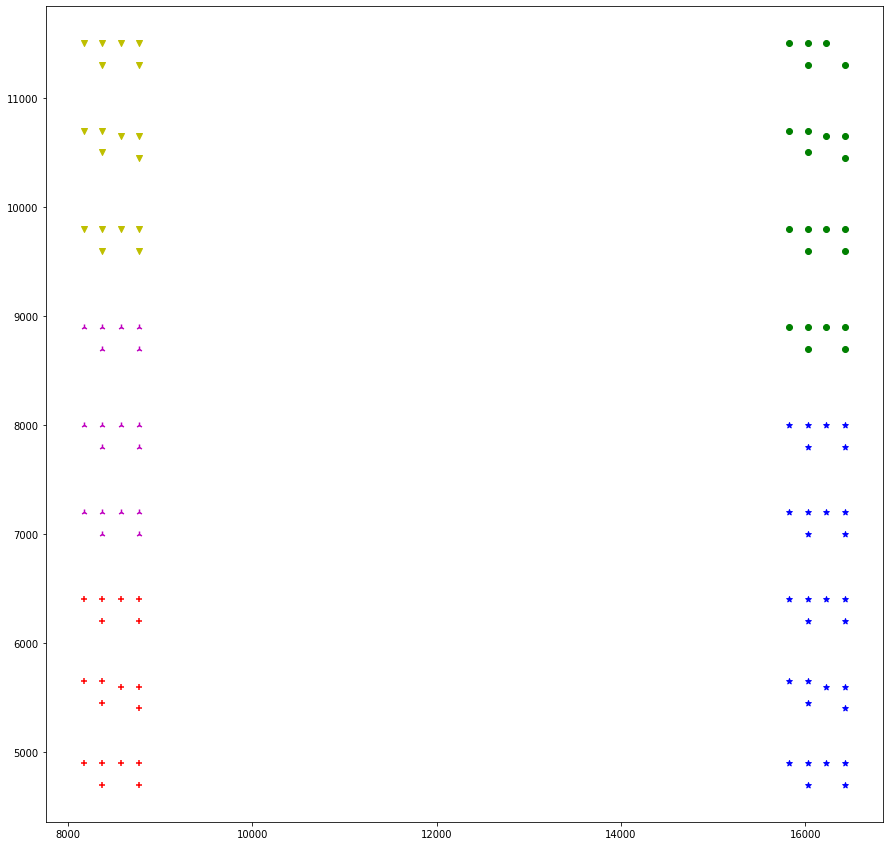

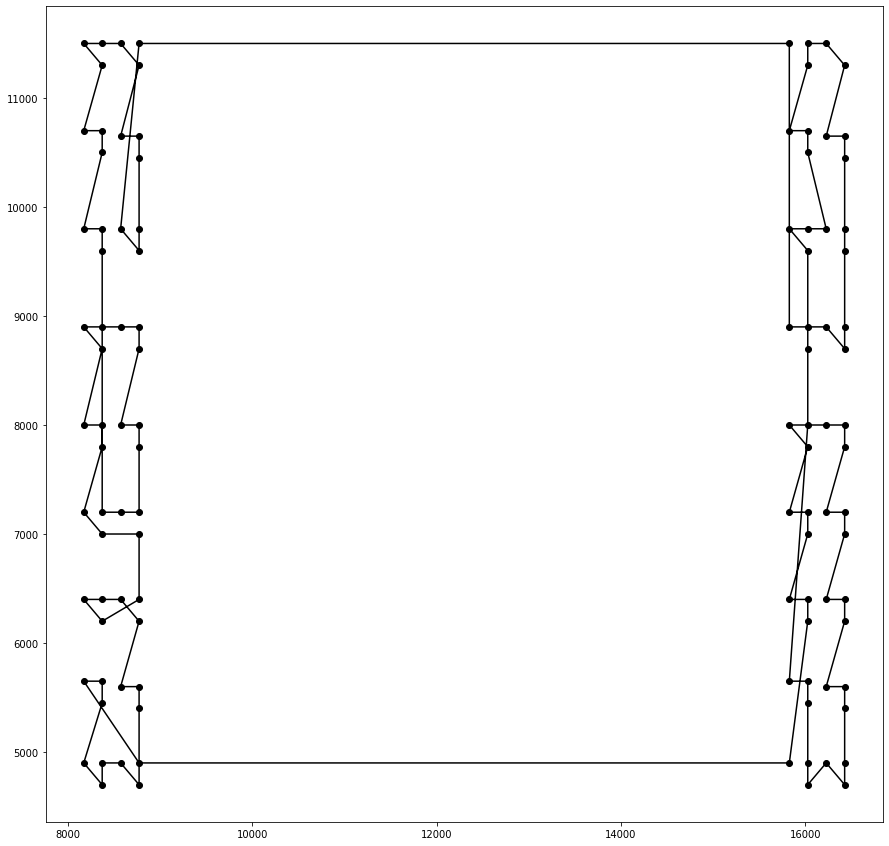

<Figure size 432x288 with 0 Axes>

In [37]:
num = 0
while num < 1:
    num += 1
    main(num)